# Determine Jacobinas(DelI for Del TMP) Analytically and Plot Them

# Values Ranges Used in Simulation (New)
Variable | Range(lower) | Range(Upper) | Point Count
----------|--------------|-------------|--------------
Materna Sturation | 0.9 | 1.0 | 5   
Maternal Hb Conc |  11 | 15| 5   
Fetal Saturation| 0.2| 0.6| 5  
Fetal Hb Conc | 11 | 15| 5  
Maternal BVF| 0.2| |    
Fetal BVF| 0.22| |   

# Values Ranges Used in Simulation (old)
Variable | Range(lower) | Range(Upper) | Point Count
----------|--------------|-------------|--------------
Materna Sturation | 0.9 | 1.0 | 5   
Maternal Hb Conc |  11 | 15| 5   
Fetal Saturation| 0.1| 0.6| 5  
Fetal Hb Conc | 0.11 | 0.15| 5  

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2
from tfo_sensitivity.jacobian import (
    MuANumericalJC,
    FullBloodAnalyticalJC,
    FullBloodJacobianMuAEqn,
    PartialBloodAnalyticalJC,
    PartialBloodJacobianMuAEqn,
    OperatingPoint,
)

# Plotting
FIG_WIDTH = 8
FIG_HEIGHT = 4
plt.style.use("seaborn")
# plt.rcParams['figure.dpi'] = 150    # Smaller plot
plt.rcParams["figure.dpi"] = 700  # Paper-ready plots

# Loading Files
maternal_wall_thickness, uterus_thickness, wave_int = 20, 5, 1
base_mu_map = MU_MAP_BASE1 if wave_int == 1 else MU_MAP_BASE2

# Defining Base Parameters 

In [33]:
# Base Parameters
MATERNAL_Hb = 11.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.50
# FETAL_Hb = 0.11
FETAL_Hb = 11.0

# Sweep Parameters
all_fetal_c = np.linspace(11, 16, 6)
# all_fetal_c = np.linspace(0.11, 0.16, 6)
all_fetal_sat = np.linspace(0.1, 0.6, 6)

PLOT_NORMALIZED = True  # Plot the Jacibian divided by Current Intensity (Similar to normalized derivative)

# Jacobian Calculator
# mu_a_eqn = FullBloodJacobianMuAEqn()    # How the mu_a is calculated for Fetal/Maternal variable layers
mu_a_eqn = PartialBloodJacobianMuAEqn(0.2, 0.1, 0.75, 0.2, 0.1, 0.75)    # How the mu_a is calculated for Fetal/Maternal variable layers

# Calculating Derivatives

In [34]:
data_table = pd.DataFrame(
    columns=["Fetal Saturation", "Fetal Concentration", "Derivative", "Type"]
)  # Types = 1, 2, 3, 4

# Comment on Types: 1 & 2 : delI/delFS, 3 & 4 : delI/delFC
# Types 1 & 3: Fetal Sat varies, Types 2 & 4: Fetal Conc varies


# Round 1 - Plots for Varying Fetal Saturation (type 1 & 3)
for fs in all_fetal_sat:
    fs = round(fs, 2)  # np.range sometimes creates weird numbers... round to 2 decimal places
    # Round 2 - Plots for Varying Fetal Concentration (type 2 & 4)
    for fc in all_fetal_c:
        fc = round(fc, 2)  # np.range sometimes creates weird numbers... round to 2 decimal places

        operating_point = OperatingPoint(MATERNAL_Hb, MATERNAL_SAT, fc, fs, wave_int)

        AnalyticalJC = MuANumericalJC(operating_point, "FS", mu_a_eqn)
        numerical_term1 = AnalyticalJC.calculate_jacobian()

        AnalyticalJC = MuANumericalJC(operating_point, "FC", mu_a_eqn)
        numerical_term2 = AnalyticalJC.calculate_jacobian()

        # Adding to Table
        new_row1 = {
            "Fetal Saturation": fs,
            "Fetal Concentration": fc,
            "Derivative": numerical_term1,
            "Type": "FS",
        }
        new_row2 = {
            "Fetal Saturation": fs,
            "Fetal Concentration": fc,
            "Derivative": numerical_term2,
            "Type": "FC",
        }
        data_table.loc[len(data_table)] = new_row1
        data_table.loc[len(data_table)] = new_row2    

# Plotting Data

Text(0.5, 1.0, 'Derivative of $\\mu_a$ w.r.t Fetal Concentration')

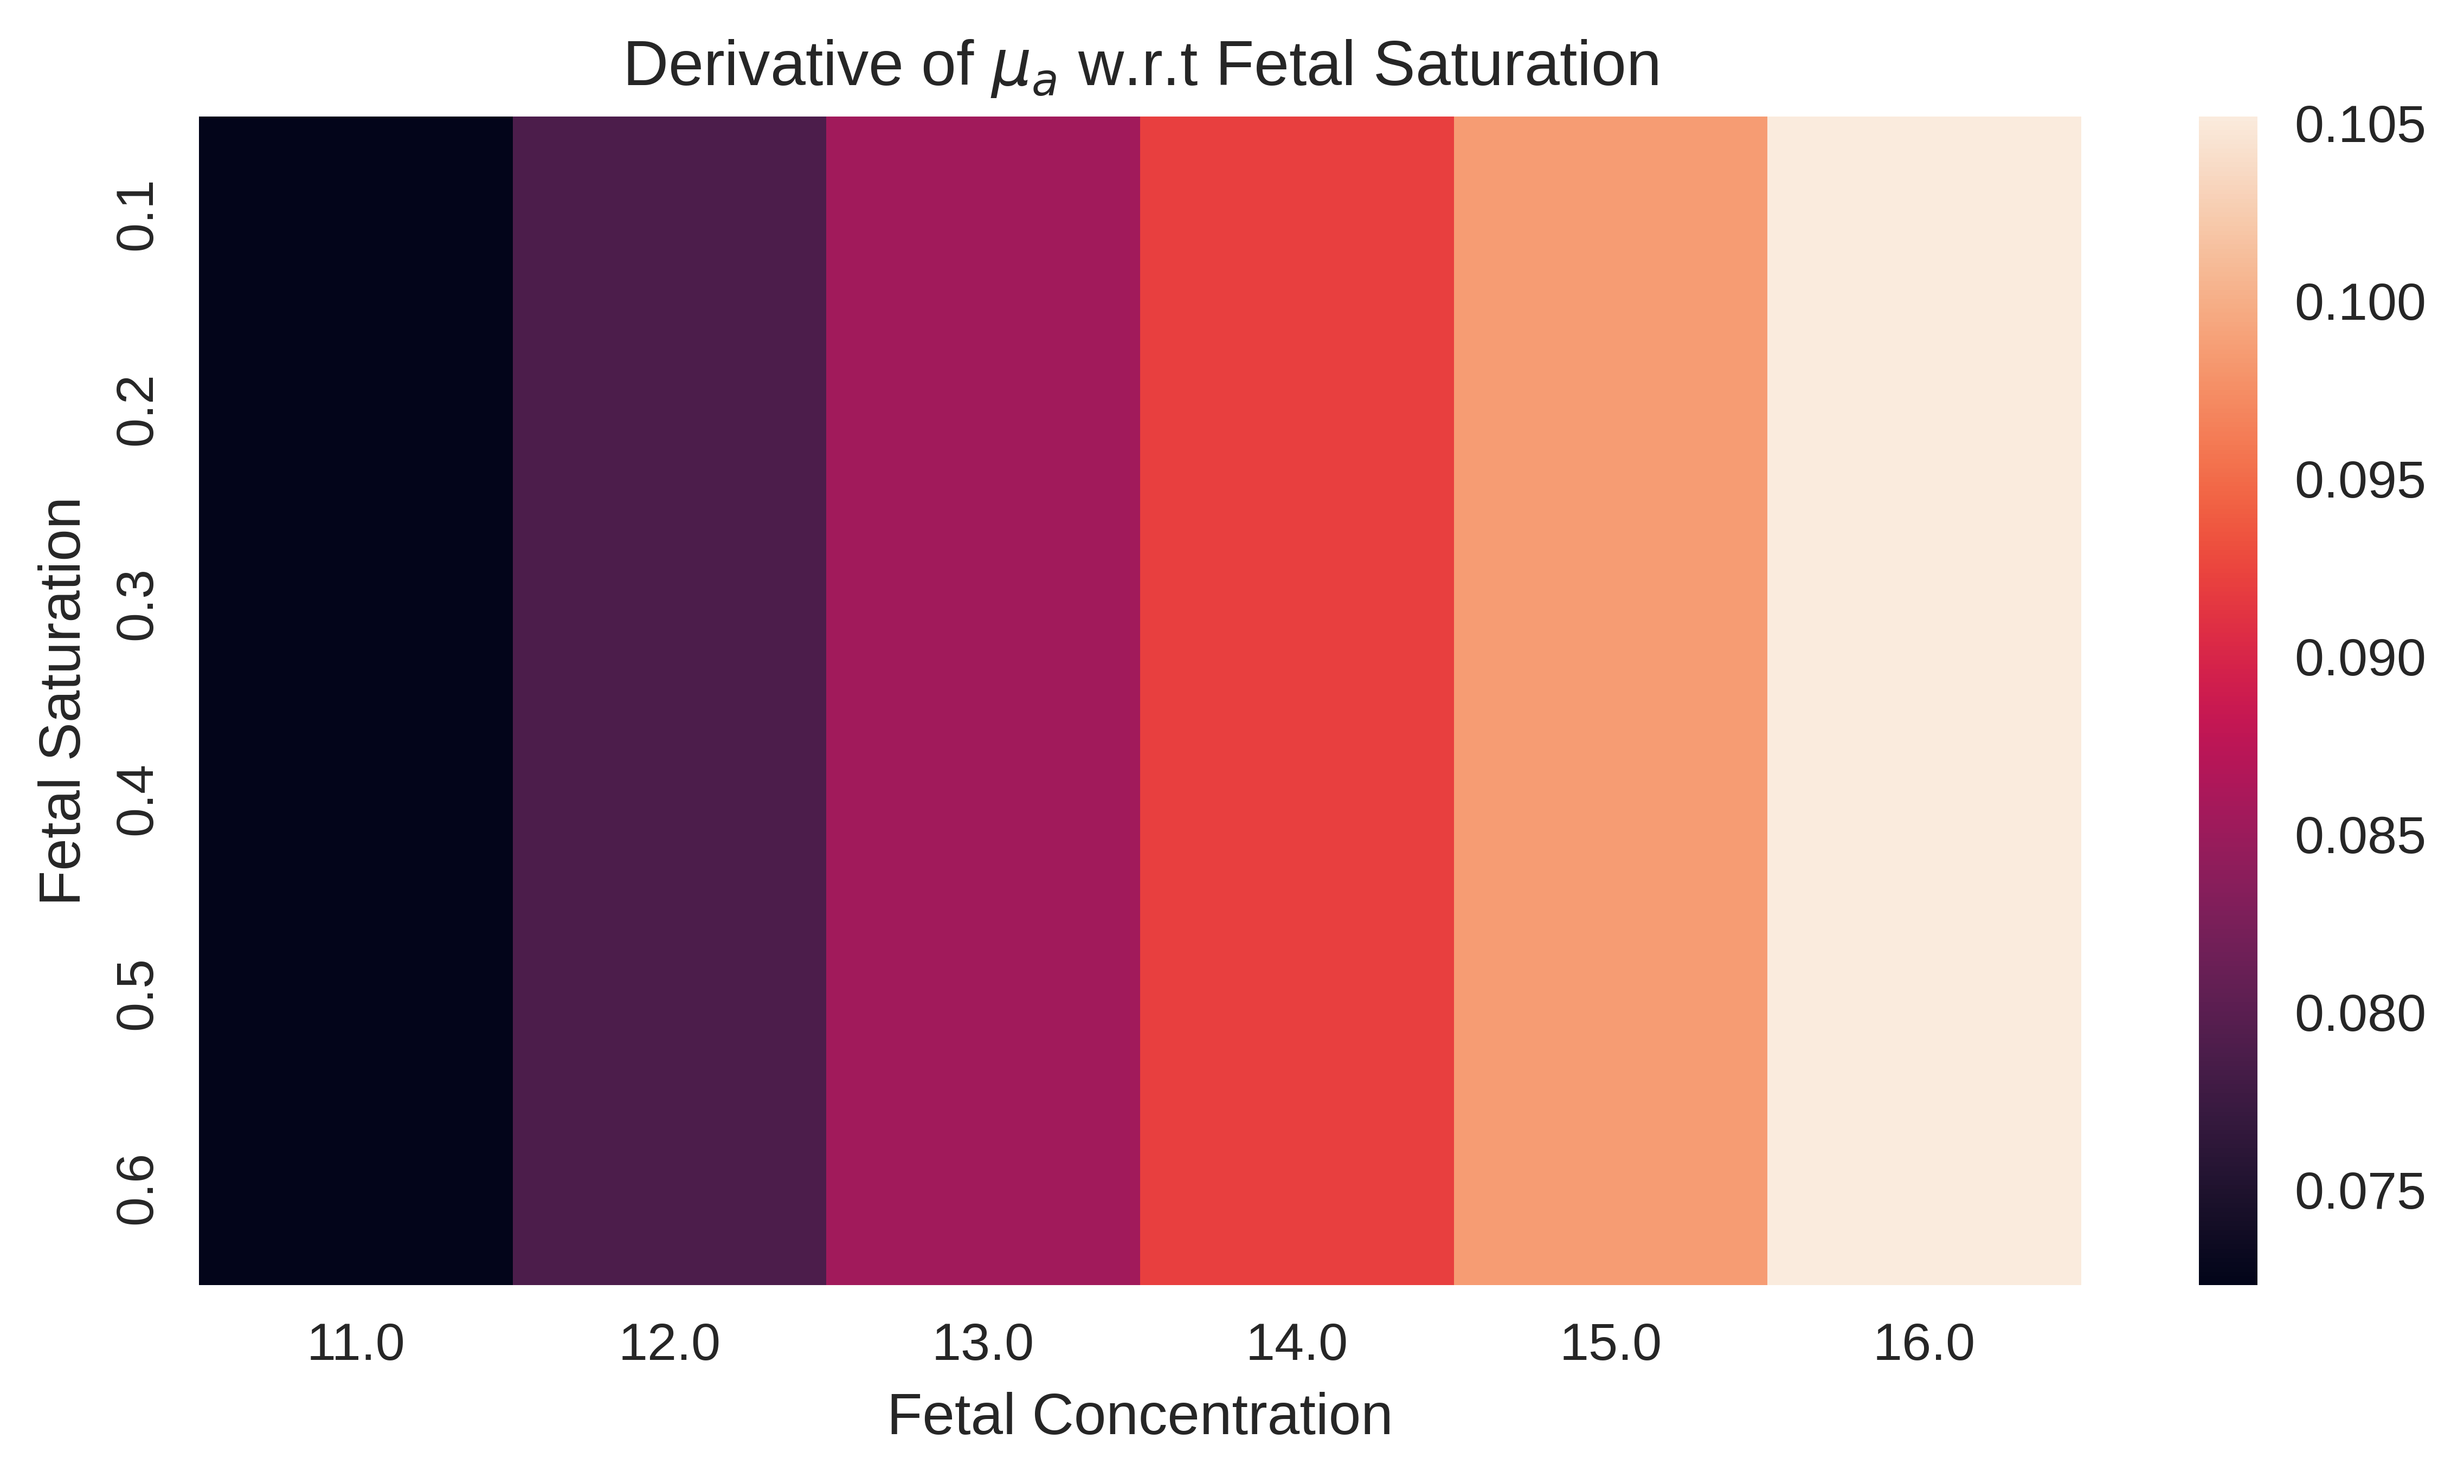

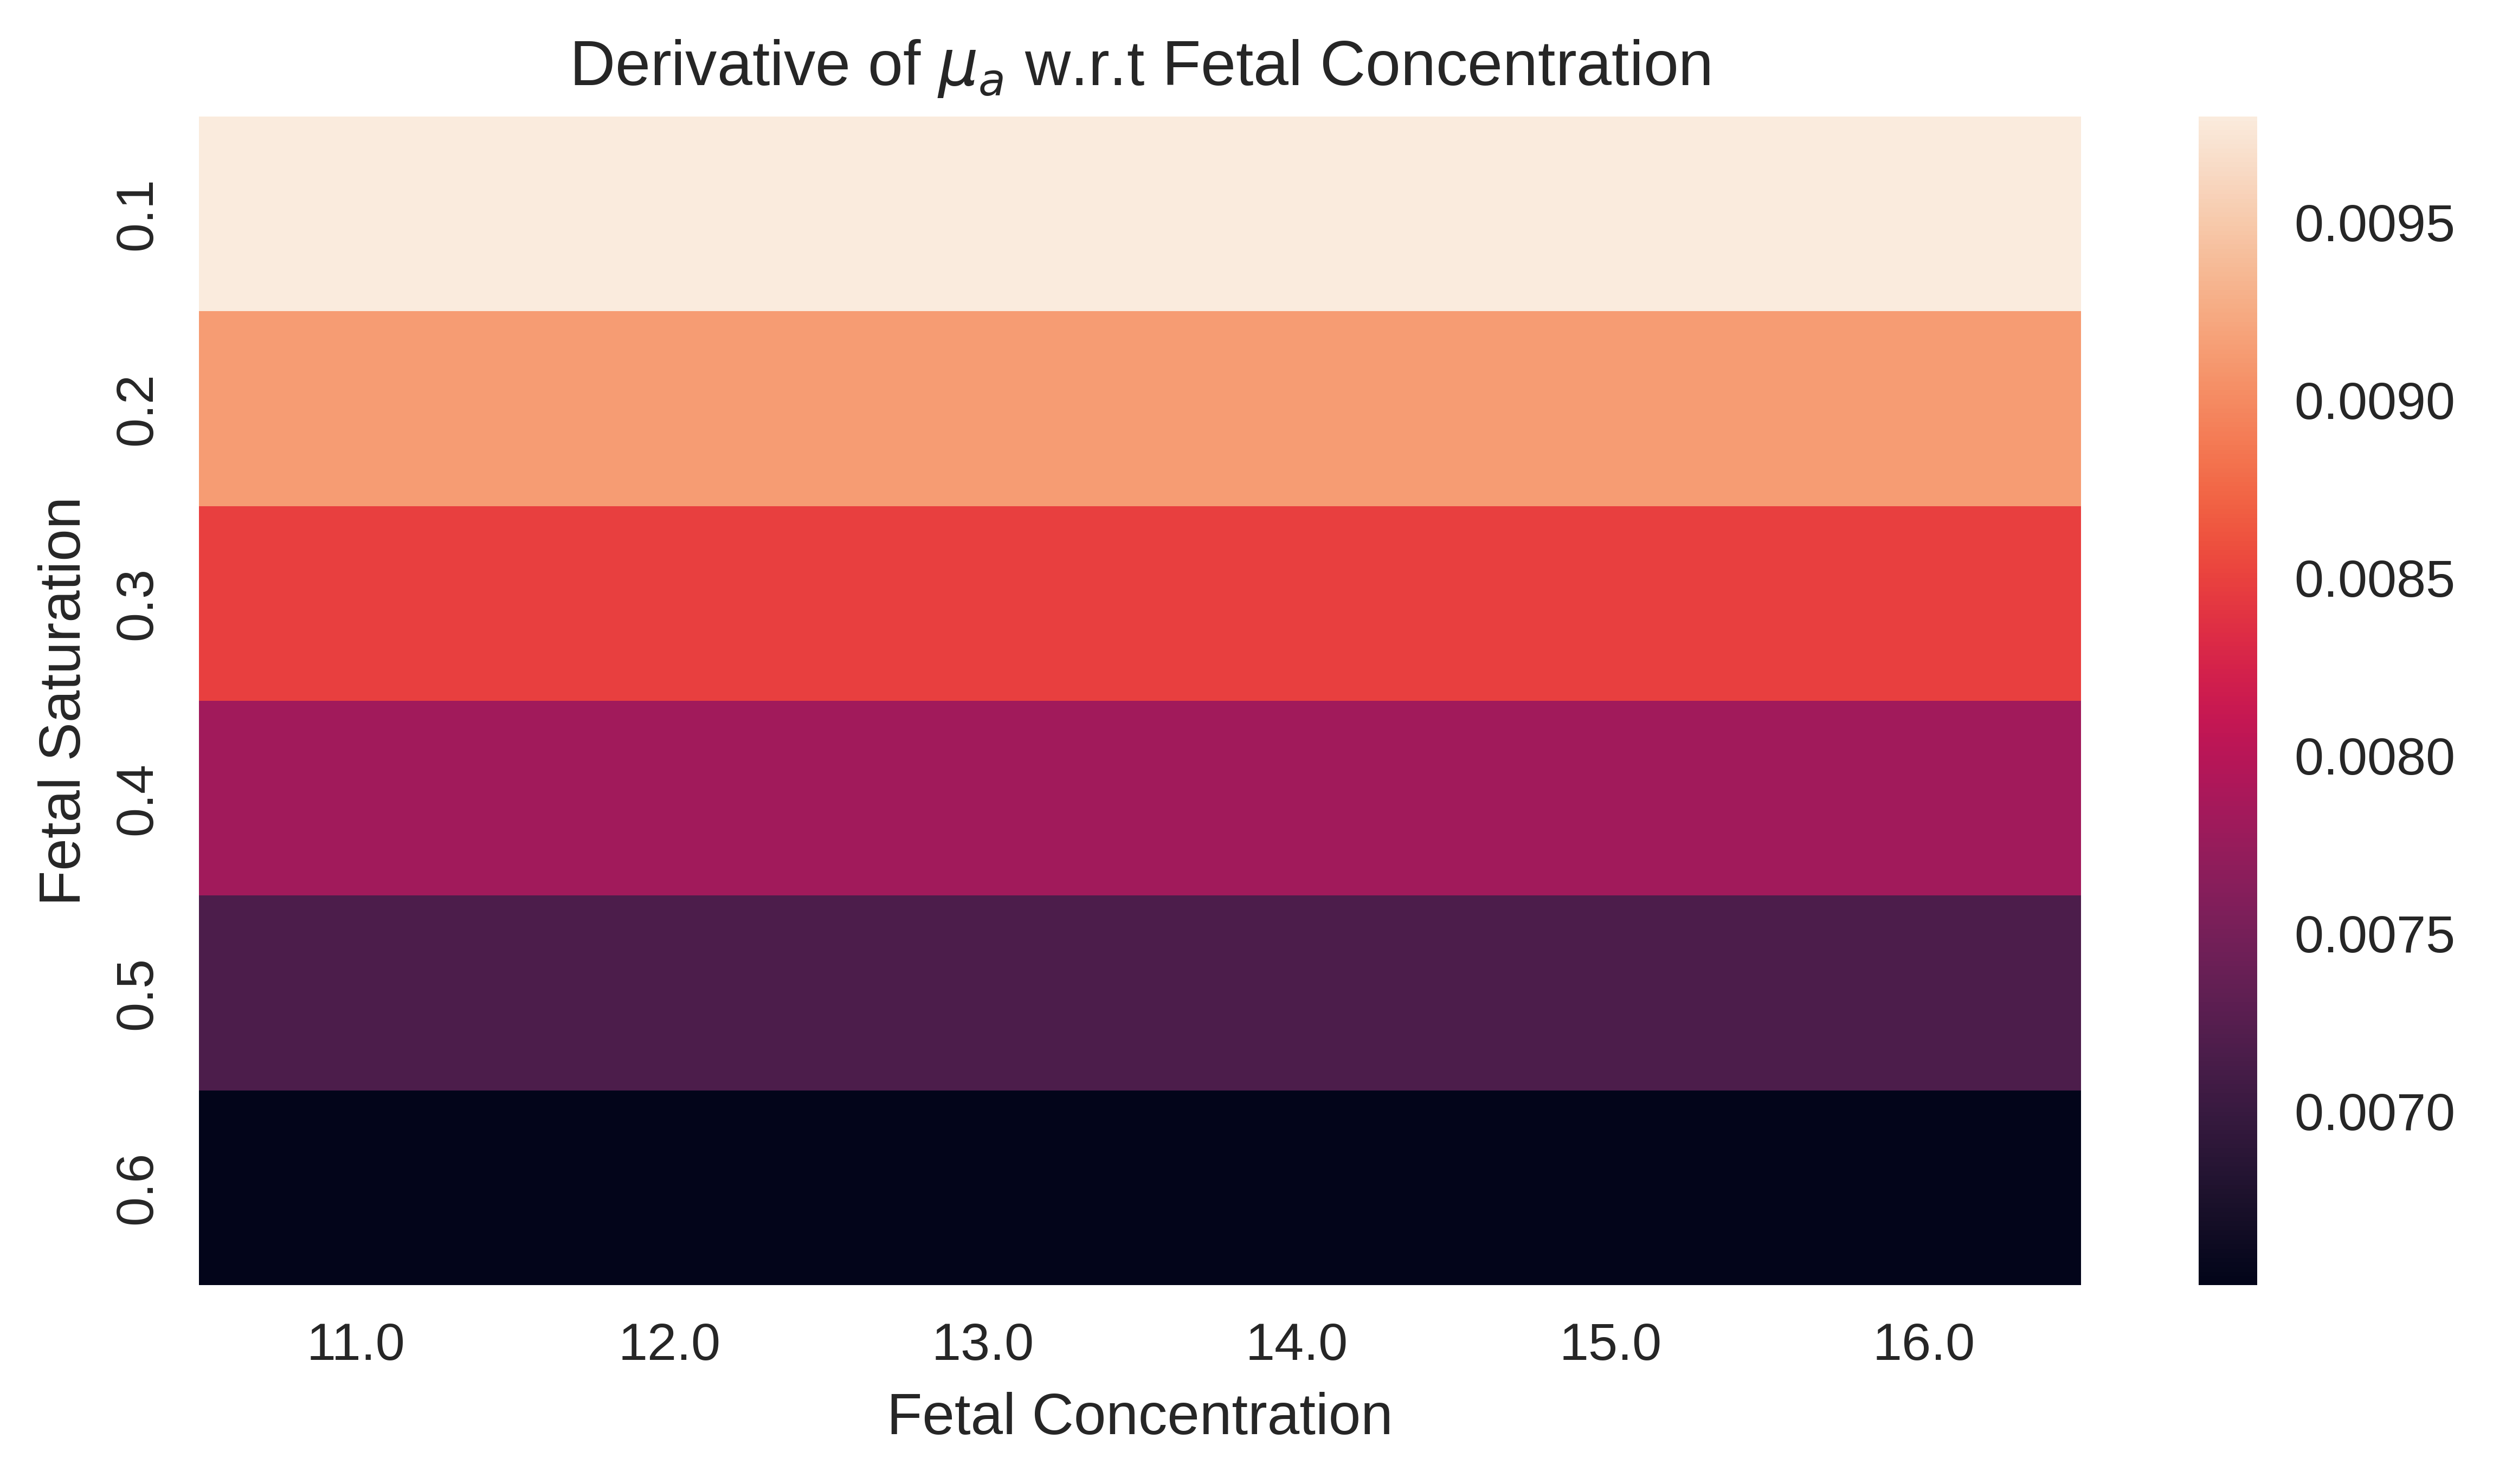

In [35]:
# Mandatory - Make all the derivatives positive
data_table['Derivative'] = data_table['Derivative'].abs()

fs_data_table : pd.DataFrame = data_table[data_table['Type'] == 'FS']
fc_data_table : pd.DataFrame= data_table[data_table['Type'] == 'FC']

plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
sns.heatmap(fs_data_table.pivot(index='Fetal Saturation', columns='Fetal Concentration', values='Derivative'))
plt.title('Derivative of $\mu_a$ w.r.t Fetal Saturation')

plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
sns.heatmap(fc_data_table.pivot(index='Fetal Saturation', columns='Fetal Concentration', values='Derivative'))
plt.title('Derivative of $\mu_a$ w.r.t Fetal Concentration')